<a href="https://colab.research.google.com/github/tokuton1024/Kaggle/blob/master/LGBM-TabularPlayground_Series_Sep2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/hiro5299834/tps-sep-2021-single-lgbm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import random
import time
import os
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [1]:
N_SPLITS = 5 #Dataの分割数
N_ESTIMATORS = 20000 #決定木の数(=反復回数)
EARLY_STOPPING_ROUNDS = 200 #早期終了させる数
VERBOSE = 1000 #学習中にどの頻度でメッセージを吐き出すか
SEED = 2021 #乱数シードを固定する

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [6]:
INPUT = "/content/drive/My Drive/Tabular Playground Series - Sep 2021/Input/"

train = pd.read_csv(INPUT + "train.csv")
test = pd.read_csv(INPUT + "test.csv")


In [7]:
Data = "/content/drive/My Drive/Tabular Playground Series - Sep 2021/Data/"
submission = pd.read_csv(Data + "sample_solution.csv")

features = [col for col in test.columns if 'f' in col]
TARGET = 'claim'

target = train[TARGET].copy()

In [8]:
train['n_missing'] = train[features].isna().sum(axis=1)
test['n_missing'] = test[features].isna().sum(axis=1)

train['std'] = train[features].std(axis=1)
test['std'] = test[features].std(axis=1)

features += ['n_missing', 'std']

In [9]:
train[features] = train[features].fillna(train[features].mean())
test[features] = test[features].fillna(test[features].mean())

In [10]:
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [11]:
train.shape, test.shape

((957919, 122), (493474, 121))

#LGBMClassifier

In [12]:
#objective:目的関数
#n_estimators:決定木の数
#random_state:乱数シード数(固定するために使う)
#learning_rate:学習率XGBでいうη(eta)決定木を作成しアップデートする際に葉のウェイトをこの比率を乗じて小さくした値を予測値に加える
#subsample:決定木ごとに学習データ行をサンプリング(Bootstrap Aggregating)する割合
#'subsample_freq': 1　perform bagging at every 1 iteration.
#n_estimators:決定木の数(=反復回数)
#reg_alpha:L1正則化のパラメータ(決定木の葉のウェイトに対する罰則)
#reg_lambda:L2正則化のパラメータ(決定木の葉のウェイトの二乗に対する罰則)
#正則化については　https://ai-trend.jp/basic-study/neural-network/regularization/　を参照
#min_child_weight:決定木を分岐させるのに必要な葉の数、100個は必要
#min_child_samples:一つの葉に最低必要なデータの数

N_ESTIMATORS = 20000
SEED = 2021

lgb_params = {
    'objective': 'binary',
    'n_estimators': N_ESTIMATORS,
    'random_state': SEED,         
    'learning_rate': 5e-3,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
    'importance_type': 'gain',
}

In [22]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()

N_SPLITS = 5 #Dataの分割数
#shuffle：Trueなら連続する数字でグループ分けせず，ランダムにデータを選択
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [23]:
VERBOSE = 1000 #学習中にどの頻度でメッセージを吐き出すか
EARLY_STOPPING_ROUNDS = 200 #早期終了させる数

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train)):
    print(f"===== fold {fold} =====")
    X_train = train[features].iloc[trn_idx]
    y_train = target.iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = target.iloc[val_idx]
    X_test = test[features]
    
    start = time.time()
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
    )


===== fold 0 =====
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's auc: 0.810282	valid_0's binary_logloss: 0.514806
[2000]	valid_0's auc: 0.812608	valid_0's binary_logloss: 0.509746
[3000]	valid_0's auc: 0.813692	valid_0's binary_logloss: 0.508828
[4000]	valid_0's auc: 0.814297	valid_0's binary_logloss: 0.508353
[5000]	valid_0's auc: 0.814711	valid_0's binary_logloss: 0.508052
[6000]	valid_0's auc: 0.814982	valid_0's binary_logloss: 0.507854
[7000]	valid_0's auc: 0.815204	valid_0's binary_logloss: 0.507705
[8000]	valid_0's auc: 0.815373	valid_0's binary_logloss: 0.507599
[9000]	valid_0's auc: 0.815492	valid_0's binary_logloss: 0.507525
[10000]	valid_0's auc: 0.815597	valid_0's binary_logloss: 0.507446
[11000]	valid_0's auc: 0.815672	valid_0's binary_logloss: 0.507396
Early stopping, best iteration is:
[11365]	valid_0's auc: 0.815698	valid_0's binary_logloss: 0.507377
===== fold 1 =====
Training until validation scores don't improve for 200 rounds.
[1000]

In [24]:
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.booster_.feature_name()
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    lgb_importances = lgb_importances.append(fi_tmp)

    lgb_oof[val_idx] = model.predict_proba(X_valid)[:, -1]
    lgb_pred += model.predict_proba(X_test)[:, -1] / N_SPLITS

    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, lgb_oof[val_idx])
    print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")

print(f"oof lgb roc = {roc_auc_score(target, lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

fold 4 - lgb auc: 0.815529, elapsed time: 4476.43sec

oof lgb roc = 0.5122584161128518


Text(0.5, 1.0, 'LightGBM feature importances')

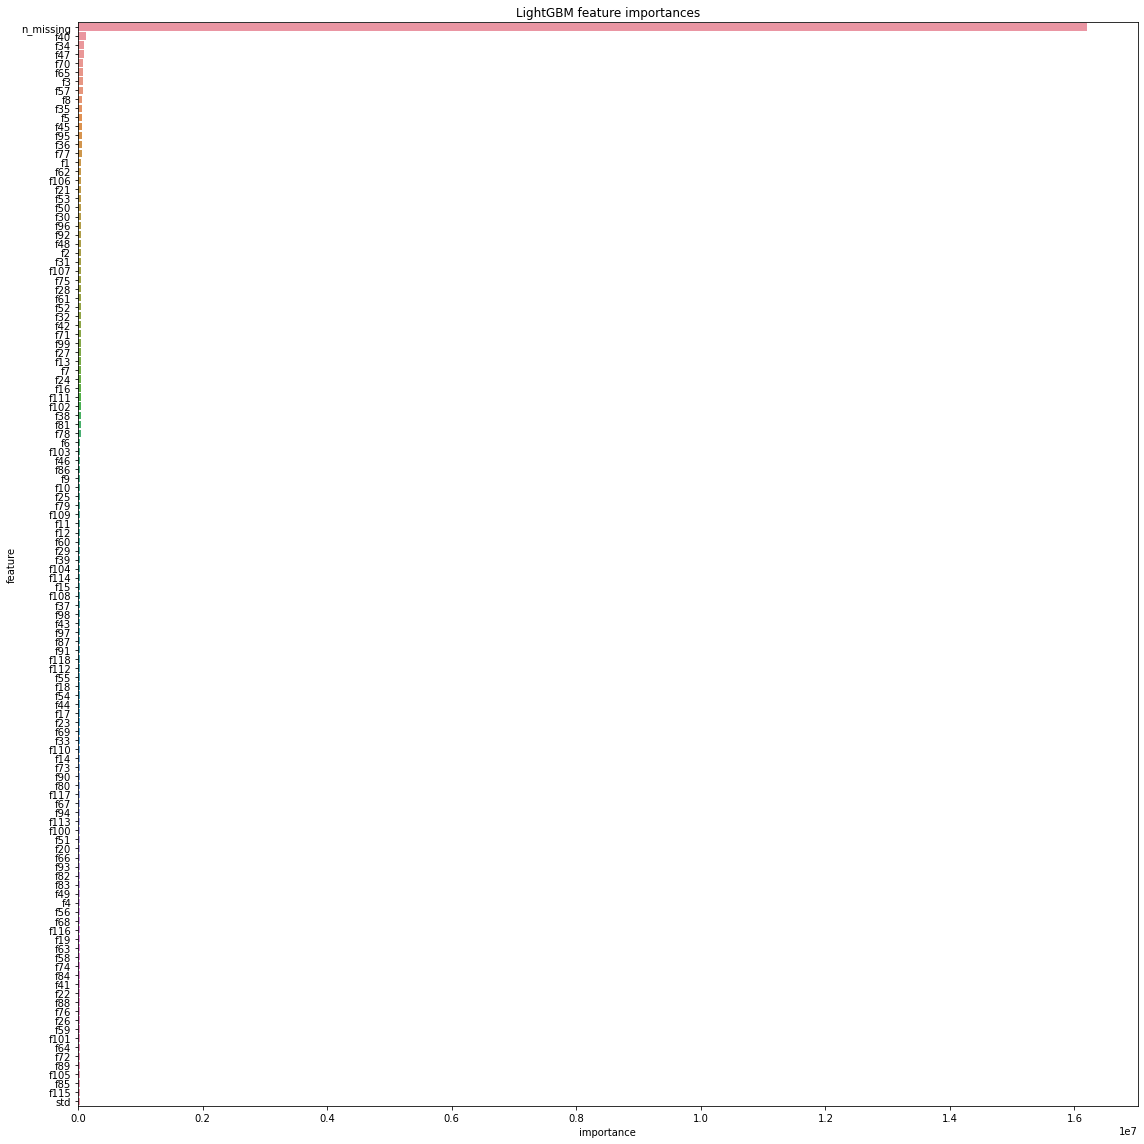

In [29]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

In [31]:
submission[TARGET] = lgb_pred
#file出力
submission.to_csv(Data + "submission.csv", index=False)